---
date: 07-02-2024
author: Martin Proks
title: Prepare datasets for web portal
---

In [1]:
import scvi
import numpy as np
import scanpy as sc
import pandas as pd


def filter_SHAP(ds_file: str, groupby: str, n: int = 10):

    df = pd.read_feather(ds_file).query('weight > 0')
    df.feature = df.feature.str.capitalize()

    filtered = df.groupby([groupby, 'feature']).count()[['iteration']].query('iteration == @n')
    df_subset = df.set_index([groupby, 'feature']).loc[filtered.index].reset_index()
    
    filtered['weight_mean'] = df_subset.groupby([groupby, 'feature']).mean().loc[filtered.index, 'weight']
    filtered['weight_std'] = df_subset.groupby([groupby, 'feature']).std().loc[filtered.index, 'weight']
    filtered['weight_ci_upper'] = filtered.weight_mean + filtered.weight_std
    filtered['weight_ci_lower'] = filtered.weight_mean - filtered.weight_std

    return filtered


def get_symbol(features: list[str]) -> np.ndarray:
    ENSG_to_SYMBOL = pd.read_csv('../proks-salehin-et-al-2023/data/external/human/Homo_sapiens.GRCh38.110.ENSG_to_SYMBOL.tsv', delimiter=" ", header=None)
    ENSG_to_SYMBOL.columns = ['ensembl','symbol']
    ENSG_to_SYMBOL_noName = pd.read_csv('../proks-salehin-et-al-2023/data/external/human/Homo_sapiens.GRCh38.110.ENSG_to_SYMBOL_noName.tsv', delimiter=" ", header=None)
    nameless_df = pd.DataFrame(
        data = {
            'ensembl' : list(set(ENSG_to_SYMBOL_noName[0].tolist()) - set(ENSG_to_SYMBOL.ensembl.tolist())),
            'symbol' : list(set(ENSG_to_SYMBOL_noName[0].tolist()) - set(ENSG_to_SYMBOL.ensembl.tolist())),
        })
    ENSG_to_SYMBOL = pd.concat([ENSG_to_SYMBOL, nameless_df])
    ENSG_to_SYMBOL.set_index('ensembl', inplace=True)

    df = pd.DataFrame(features, index=features, columns=['symbol'])
    common_genes = np.intersect1d(features, ENSG_to_SYMBOL.index)
    df.loc[common_genes, 'symbol'] = ENSG_to_SYMBOL.loc[common_genes, 'symbol']

    return df.symbol.values

/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [2]:
MOUSE_STAGE_COLORS = {
    'Zygote': '#7985A5',
    '2C': '#B3C81E',
    '4C': '#67BB30',
    '8C': '#028A46',
    '16C': '#657cbd',
    'ICM': '#F6C445',
    'TE': '#5a94ce',
    'EPI': '#B46F9C',
    'PrE': '#D05B61'
}

MOUSE_CT_COLORS = {
    'Zygote': '#7985A5',
    '2C': '#B3C81E',
    '4C': '#67BB30',
    '8C': '#028A46',
    '16C': '#657cbd',
    'E3.25-ICM': '#fadc8f',
    'E3.25-TE': '#5185b9',
    'E3.5-ICM': '#f8d06a',
    'E3.5-TE': '#7ba9d8',
    'E3.5-EPI': '#c38cb0',
    'E3.5-PrE': '#d97c81',
    'E3.75-ICM': '#F6C445',
    'E4.5-TE': '#5a94ce',
    'E4.5-EPI': '#B46F9C',
    'E4.5-PrE': '#D05B61'
}

HUMAN_STAGE_COLORS = {
    'Oocyte': '#000000',
    'Zygote': '#7985A5',
    'Pronucleus': '#555d73',
    '2C': '#B3C81E',
    '4C': '#67BB30',
    '8C': '#028A46',
    'Morula': '#657cbd',
    'ICM': '#F6C445',
    'TE': '#5a94ce',
    'EPI': '#B46F9C',
    'PrE': '#D05B61',
    'Unknown': '#F1BD93'
}

HUMAN_CT_COLORS = {
    'Prelineage': '#7985A5',
    '8C_3.0': '#028A46',
    'Morula_4.0': '#657cbd',
    'Inner Cell Mass': '#F6C445',
    'Primitive Endoderm': '#D05B61',
    'Epiblast_6.0': '#d6b2ca',
    'Epiblast_7.0': '#c38db1',
    'Late epiblast': '#aa5c8f',
    'Trophectoderm_5.0': '#cddff0',
    'Trophectoderm_6.0': '#bdd4eb',
    'Trophectoderm_7.0': '#acc9e6',
    'Trophectoderm_8.0': '#9cbfe2',
    'Trophectoderm_9.0': '#8bb4dd',
    'Trophectoderm_10.0': '#5a94ce',
    'Unknown': '#F1BD93',
}

In [3]:
lvae = scvi.model.SCANVI.load("../proks-salehin-et-al-2023/results/02_mouse_integration/scanvi_ns_15/")
mouse = sc.read_h5ad("../proks-salehin-et-al-2023/results/03_mouse.processed.h5ad")

mouse.obs["predictions"] = lvae.predict()
mouse.obs['entropy'] = 1 - lvae.predict(soft=True).max(axis=1)
mouse.uns['stage_colors'] = [MOUSE_STAGE_COLORS[x] for x in mouse.obs.stage.cat.categories]
mouse.uns['ct_colors'] = [MOUSE_CT_COLORS[x] for x in mouse.obs.ct.cat.categories]

sc.pp.neighbors(mouse, use_rep='X_scVI')
sc.tl.diffmap(mouse)
sc.tl.paga(mouse, groups='ct')
sc.tl.draw_graph(mouse, init_pos='paga', n_jobs=10)

mouse.uns['log1p'] = {'base': None}
sc.tl.rank_genes_groups(mouse, groupby="ct", use_raw=True)
sc.tl.rank_genes_groups(mouse, groupby="stage", use_raw=True, key_added="degs_stage")

INFO     File ../proks-salehin-et-al-2023/results/02_mouse_integration/scanvi_ns_15/model.pt already downloaded    


/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fdb589/projects/data/Brickman/conda/envs/scvi- ...
  rank_zero_warn(
/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/umap/distan

In [4]:
lvae_human = scvi.model.SCANVI.load("../proks-salehin-et-al-2023/results/02_human_integration/05_scanvi_ns15/")
human = lvae_human.adata
human.obs.ct = human.obs.C_scANVI_nsamples

human.obs[['dpt_pseudotime', 't', 'seg', 'edge', 't_sd', 'milestones']] = sc.read_h5ad("../proks-salehin-et-al-2023/results/03_human.processed.h5ad")\
    .obs[['dpt_pseudotime', 't', 'seg', 'edge', 't_sd', 'milestones']]\
    .loc[human.obs_names]
human.obs["predictions"] = lvae_human.predict()
human.obs['entropy'] = 1 - lvae_human.predict(soft=True).max(axis=1)
human.uns['stage_colors'] = [HUMAN_STAGE_COLORS[x] for x in human.obs.stage.cat.categories]
human.uns['C_scANVI_nsamples_colors'] = [HUMAN_CT_COLORS[x] for x in human.obs.C_scANVI_nsamples.cat.categories]

human.uns['log1p'] = {'base': None}
sc.tl.rank_genes_groups(human, groupby="ct", use_raw=True)
sc.tl.rank_genes_groups(human, groupby="stage", use_raw=True, key_added="degs_stage")

INFO     File ../proks-salehin-et-al-2023/results/02_human_integration/05_scanvi_ns15/model.pt already downloaded  


/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fdb589/projects/data/Brickman/conda/envs/scvi- ...
  rank_zero_warn(


## Gene expression

/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


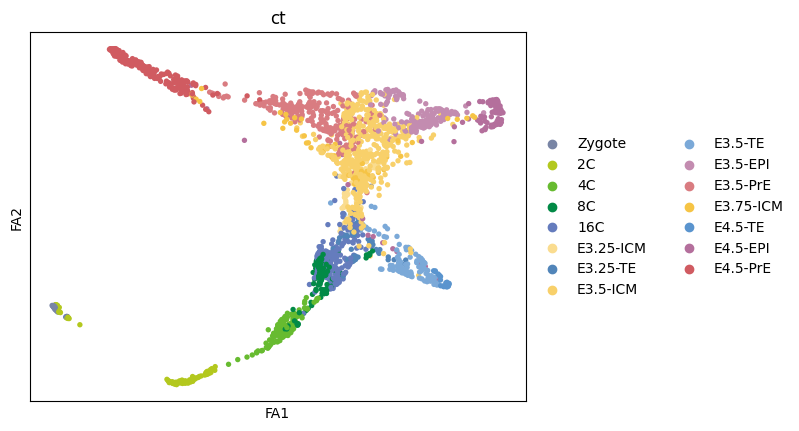

In [5]:
sc.pl.draw_graph(mouse, color='ct')

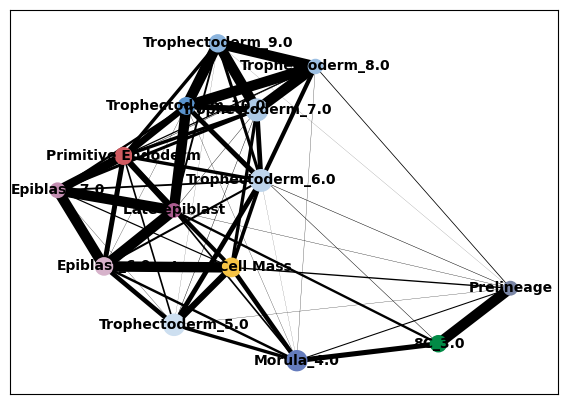

In [6]:
sc.pp.neighbors(human, use_rep='X_scVI')
sc.tl.umap(human)
sc.tl.diffmap(human)
sc.tl.paga(human, groups='C_scANVI_nsamples')
sc.pl.paga(human)
sc.tl.draw_graph(human, init_pos='paga', n_jobs=10)

/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


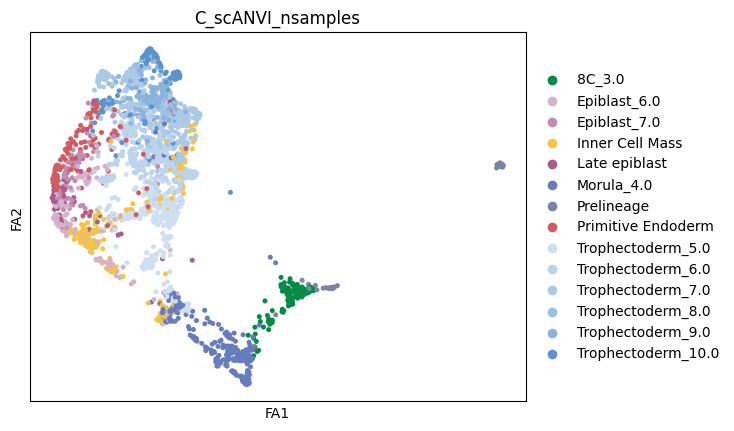

In [7]:
sc.pl.draw_graph(human, color='C_scANVI_nsamples')

## Degs

In [8]:
df = sc.get.rank_genes_groups_df(mouse, group=None)
df.assign(gene_symbol=df.names).to_feather("static/mouse_degs_ct.feather")

df = sc.get.rank_genes_groups_df(mouse, group=None, key="degs_stage")
df.assign(gene_symbol=df.names).to_feather("static/mouse_degs_stage.feather")

In [9]:
df = sc.get.rank_genes_groups_df(human, group=None)
df.assign(gene_symbol=get_symbol(df.names)).to_feather("static/human_degs_ct.feather")

sc.get.rank_genes_groups_df(human, group=None, key="degs_stage")
df.assign(gene_symbol=get_symbol(df.names)).to_feather("static/human_degs_stage.feather")

## SHAP values

In [10]:
mouse_SHAP = filter_SHAP("../proks-salehin-et-al-2023/results/00_mouse_scANVI_deepexplainer.feather", groupby="ct")\
    .sort_values('weight_mean', ascending=False)\
    .groupby('ct')\
    .head(-1)\
    .reset_index()\
    .set_index(['ct', 'feature'])\
    .loc[mouse.obs.ct.cat.categories]

markers = pd.concat([sc.get.rank_genes_groups_df(mouse, group=ct).assign(ct=ct) for ct in mouse.obs.ct.cat.categories]).set_index(['ct', 'names'])

common = mouse_SHAP.index.intersection(markers.index)
mouse_SHAP.loc[common, 'logfoldchanges'] = markers.loc[common, 'logfoldchanges'].values
mouse_SHAP.loc[common, 'pvals_adj'] = markers.loc[common, 'pvals_adj'].values
mouse_SHAP.loc[common, 'scores'] = markers.loc[common, 'scores'].values

mouse_SHAP.reset_index().to_feather("static/mouse_SHAP.feather")

/scratch/temp/fdb589/ipykernel_2672766/2376364135.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  filtered['weight_mean'] = df_subset.groupby([groupby, 'feature']).mean().loc[filtered.index, 'weight']
/scratch/temp/fdb589/ipykernel_2672766/2376364135.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  filtered['weight_std'] = df_subset.groupby([groupby, 'feature']).std().loc[filtered.index, 'weight']


In [11]:
human_SHAP = filter_SHAP("../proks-salehin-et-al-2023/results/00_human_scANVI_deepexplainer.feather", groupby="ct")\
    .sort_values('weight_mean', ascending=False)\
    .groupby('ct')\
    .head(-1)\
    .reset_index()\
    .assign(feature = lambda x: x.feature.str.upper())\
    .set_index(['ct', 'feature'])\
    .loc[human.obs.C_scANVI_nsamples.cat.categories]

markers = pd.concat([sc.get.rank_genes_groups_df(human, group=ct).assign(ct=ct) for ct in human.obs.C_scANVI_nsamples.cat.categories]).set_index(['ct', 'names'])

common = human_SHAP.index.intersection(markers.index)
human_SHAP.loc[common, 'logfoldchanges'] = markers.loc[common, 'logfoldchanges'].values
human_SHAP.loc[common, 'pvals_adj'] = markers.loc[common, 'pvals_adj'].values
human_SHAP.loc[common, 'scores'] = markers.loc[common, 'scores'].values

human_SHAP = human_SHAP.reset_index()\
    .assign(feature = get_symbol(human_SHAP.reset_index().feature))\
    .set_index(['ct', 'feature'])

human_SHAP.reset_index().to_feather("static/human_SHAP.feather")

/scratch/temp/fdb589/ipykernel_2672766/2376364135.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  filtered['weight_mean'] = df_subset.groupby([groupby, 'feature']).mean().loc[filtered.index, 'weight']
/scratch/temp/fdb589/ipykernel_2672766/2376364135.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  filtered['weight_std'] = df_subset.groupby([groupby, 'feature']).std().loc[filtered.index, 'weight']


## Save files

In [12]:
from scipy import sparse

mouse_compressed = sc.AnnData(
    X = mouse.X,
    obs = mouse.obs[['batch', 'experiment', 'technology', 'ct', 'ct_orig', 'stage','timepoint', 
           'total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'leiden', 
           'dpt_pseudotime', 't', 'seg', 'edge', 't_sd', 'milestones', 'entropy', 'predictions']],
    var = mouse.var[['gene_ids', 'gene_symbol']],
    uns={ x: mouse.uns[x] for x in ['_scvi_manager_uuid', '_scvi_uuid', 'ct_colors', 'ct_sizes', 'experiment_colors', 'seg_colors', 'stage_colors', 'timepoint_colors']},
    obsm={ x: mouse.obsm[x] for x in ['X_diffmap', 'X_diffmap_', 'X_draw_graph_fa', 'X_mde_scVI', 'X_pca', 'X_phate', 'X_scVI', 'X_tsne', 'X_umap']},
    layers={'scVI_normalized': sparse.csr_matrix(mouse.layers['scVI_normalized'])},
    raw = mouse.raw
)

tmp_raw = human.raw.to_adata()
tmp_raw.var = pd.DataFrame(tmp_raw.var.reset_index().values, index=get_symbol(tmp_raw.var.reset_index()['index'].ravel()), columns=['index'])

human_compressed = sc.AnnData(
    X = human.X,
    obs = human.obs,
    var = human.var.reset_index().set_index('symbol')[['index']],
    uns={ x: human.uns[x] for x in ['_scvi_manager_uuid', '_scvi_uuid', 'stage_colors', 'C_scANVI_nsamples_colors', 'C_scANVI_nsamples_sizes']},
    obsm={ x: human.obsm[x] for x in ['X_mde_scANVI', 'X_mde_scVI', 'X_scANVI', 'X_scVI', 'X_diffmap', 'X_draw_graph_fa']},
    layers={'scVI_normalized': sparse.csr_matrix(human.layers['scVI_normalized'])},
    raw = tmp_raw
)

mouse_compressed.write("static/portal_mouse_v1.1.h5ad")
human_compressed.write("static/portal_human_v1.1.h5ad")

/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
